In [2]:
pip install pydicom

     |████████████████████████████████| 1.9MB 4.7MB/s 


In [ ]:
 %tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install keras==2.1.5

In [3]:
import os
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tqdm
from tqdm import tqdm_notebook
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
import tensorflow as tf
from tensorflow import keras
import os
import csv
import random
import pydicom
from skimage import io
from skimage import measure
from skimage.transform import resize
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,LeakyReLU,ReLU,GaussianDropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
%matplotlib inline 
PATH='/drive/MyDrive/GL_AIML/Capstone/'


## Above we configure our notebook for googel colab, install/import necessary libraries and versions

In [ ]:
train = pd.read_csv('/drive/MyDrive/GL_AIML/Capstone/stage_2_train_labels.csv')
classes = pd.read_csv('/drive/MyDrive/GL_AIML/Capstone/stage_2_detailed_class_info.csv') 

## Configuring our train class info csv file as classes
## Configuring our training image set info as train

In [ ]:
train

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
...                                     ...    ...    ...    ...     ...   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  
0           0  
1           0  
2           0  
3           0  
4           1  
...       ...  
30222       1  
30223       0  
30224       0  
30225       1  
30226       1  

[30227 rows x 6 columns]

## Train has patient id's of patients along with bounding box coordinates of the opacity in the xray
## We have a target column which is binary and tells us if that particular patinet had pneumonia or not

In [ ]:
classes

patientId                         class
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2      00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4      00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
...                                     ...                           ...
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8                  Lung Opacity
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba                        Normal
30224  c1f6b555-2eb1-4231-98f6-50a963976431                        Normal
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity

[30227 rows x 2 columns]

## Classes also has patient id's along with the class that it belongs to

In [ ]:
classes['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

## Classes here are 
### 1. No Lung Opacity / Not Normal
### 2. Normal
### 3. Lung Opacity
## Here we get a baisc idea of whether the patient tested positive or negative for pneumonia

In [ ]:
print(f"Classes Summary-----> Data Points: {classes.shape[0]}, Classes: {classes.shape[1]}")
print(f"Train Data Summary-----> Data Points: {train.shape[0]}, features: {train.shape[1]}")

Classes Summary-----> Data Points: 30227, Classes: 2
Train Data Summary-----> Data Points: 30227, features: 6


## Our classes dataframe has 30227 rows and 2 columns
## Our train dataframe has 30227 rows and 6 columns

In [ ]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))



## This above function will help us check the missing values and the % number compared to full data

In [ ]:
def get_feature_distribution(data, feature):
    label_counts = data[feature].value_counts()
    total_samples = len(data)
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))



## This function gives us the % of data in each class against the total

In [ ]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join('stage_2_train_images',patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

## The above function helps us explore and view our images along with the dicom files. Medical images are preserved in peculiar format called DICOM files with extension *.dcm . It has combination of header metadata and underlying raw image array. Python has support for this and the best module to be used is the pydicom module

In [ ]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join('stage_2_train_images',patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train[train['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

## Same fucntion but with bounding boxes

In [ ]:
missing_data(train)

height         width             y             x  Target  \
Total    20672.000000  20672.000000  20672.000000  20672.000000     0.0   
Percent     68.389188     68.389188     68.389188     68.389188     0.0   

         patientId  
Total          0.0  
Percent        0.0

## We check missing values in our train dataframe
## There are an ample amount in co ordinates since xray images with no Pneumonia needs no bouding boxes
## Hence H,W,X,W would be nan for class 0
## We shall not change it and let it be, because these will be handy further, since we can easily separte classes by filtering with np.nan

In [ ]:
missing_data(classes)

class  patientId
Total      0.0        0.0
Percent    0.0        0.0

## The classes dataframe is free of null values 

/Users/chiraglodaya/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


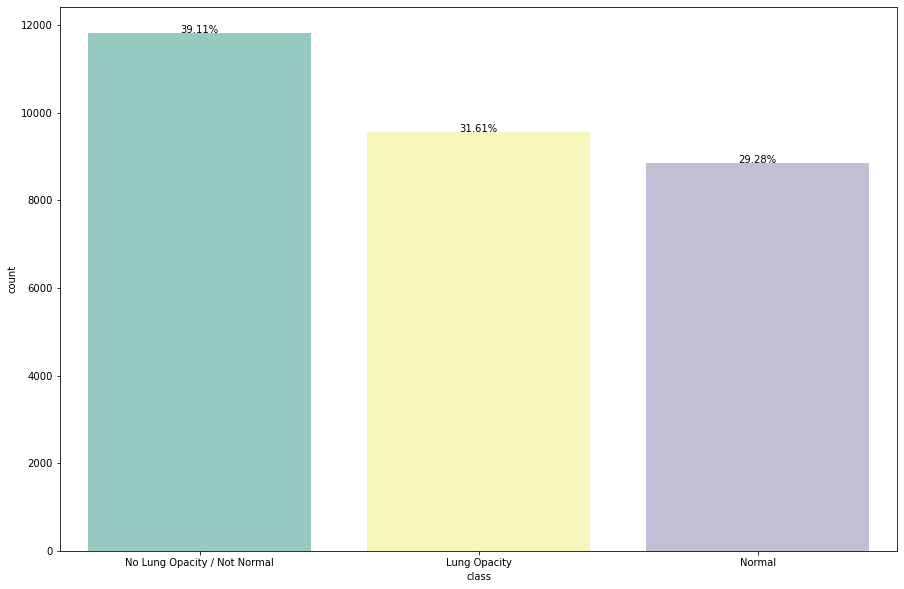

In [ ]:
f, ax = plt.subplots(1,1, figsize=(15,10))
total = float(len(classes))
sns.countplot(classes['class'],order = classes['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [ ]:
get_feature_distribution(classes, 'class')

Feature: class
No Lung Opacity / Not Normal  :   11821 or 39.1%
Lung Opacity                  :   9555 or 31.61%
Normal                        :   8851 or 29.28%


## Above we see our target class distribution
## No Lung Opacity / Not Normal is ~ 39% which is negative class along with another negative class Normal which is ~30%
## Our positive class Lung Opacity is ~31%

In [ ]:
train2 = train.merge(classes, left_on='patientId', right_on='patientId', how='inner')
train2

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
...                                     ...    ...    ...    ...     ...   
37624  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
37625  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
37626  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
37627  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   
37628  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target                         class  
0           0  No Lung Opacity / Not Normal  
1           0  No Lung Opacity / Not Normal  
2           0  No Lung Opacity / Not Normal  
3           0                        Normal  
4           1                  Lung Opacity  
...       ...                           ...  
37624       0                        Normal  
37625       1                  Lung Opacity  
37626       1                  Lung Opacity  
37627       1                  Lung Opacity  
37628       1                  Lung Opacity  

[37629 rows x 7 columns]

## We next merge the datafarmes into a single train dataframe for better usage

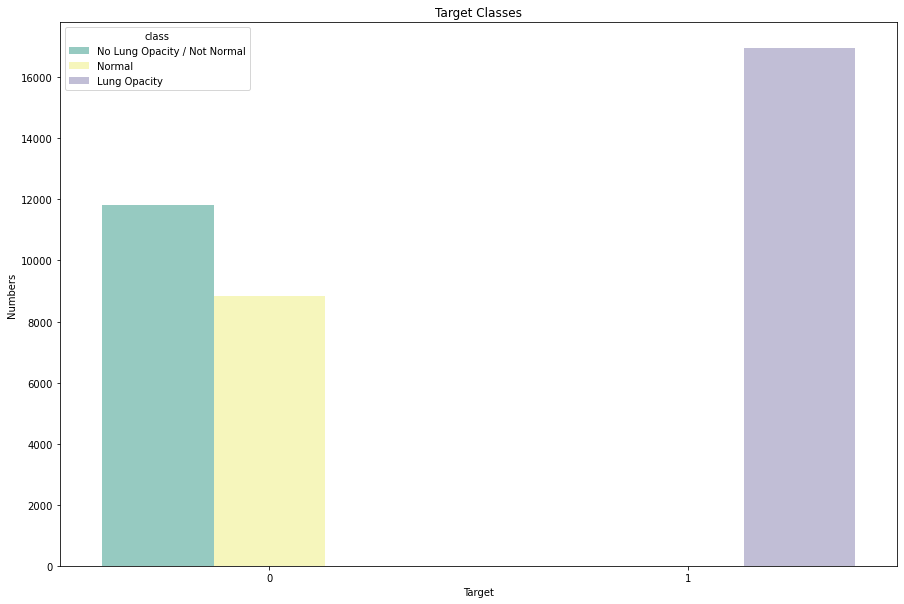

In [ ]:
fig, ax = plt.subplots(nrows=1,figsize=(15,10))
tmp = train2.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Numbers': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Numbers',hue='class',data=df, palette='Set3')
plt.title("Target Classes")
plt.show()

## We now check overall distribution of our classes positive and negative
## Positive is almost 69% and negative class is 31%
## We get an idea that class imbalance is not a case here

/Users/chiraglodaya/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chiraglodaya/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chiraglodaya/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

<Figure size 432x288 with 0 Axes>

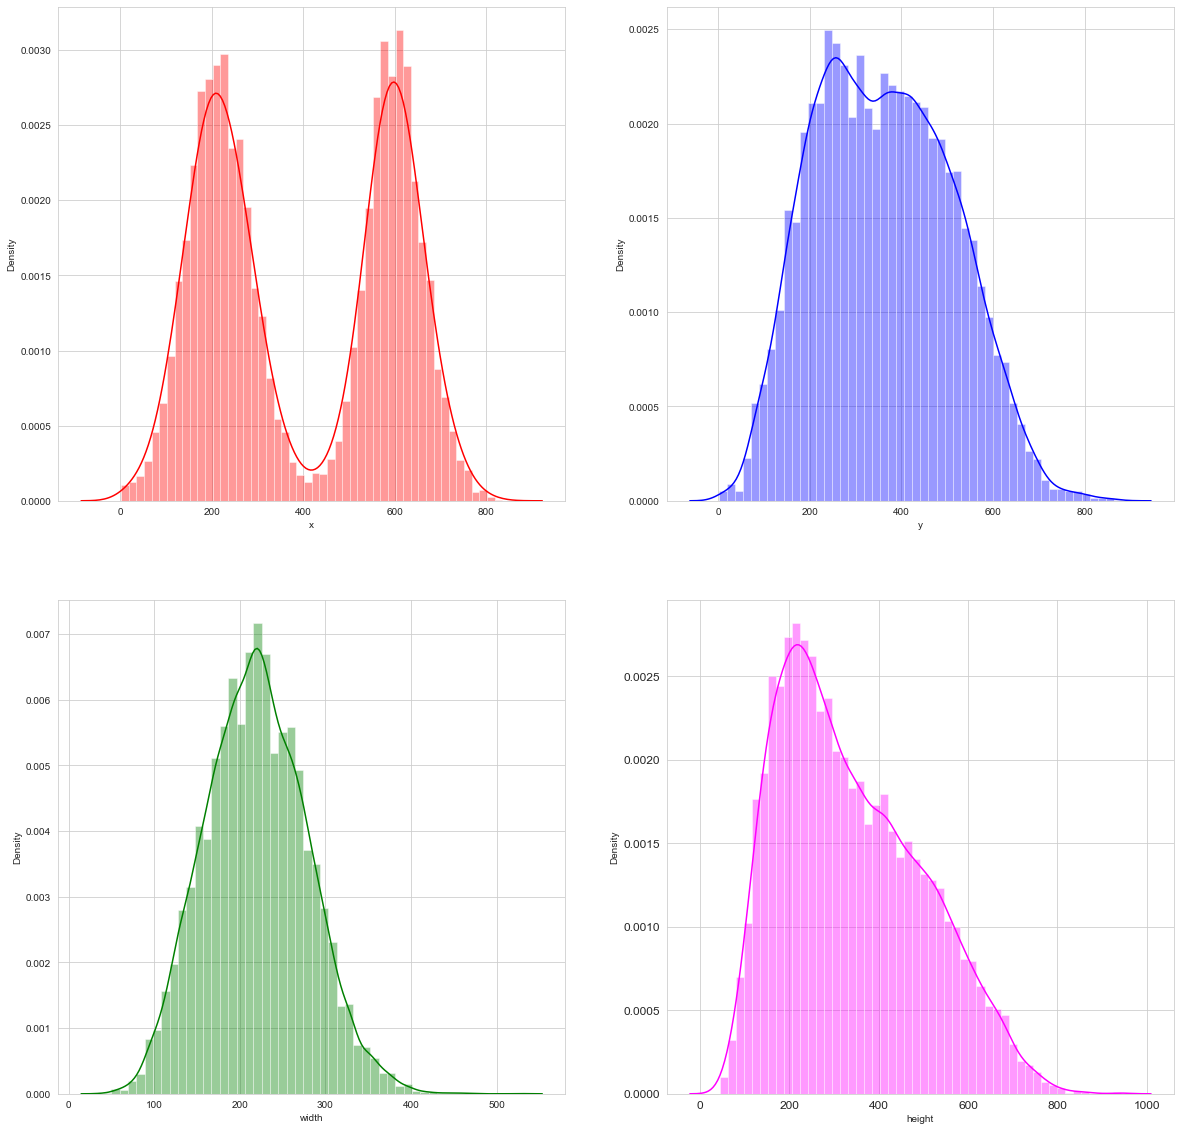

In [ ]:
target1 = train2[train2['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(20,20))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## We check the distribution of our x,y,h,w
## Y, H, W seem to be normally distributed but X seems worrysome with bimodal disrtibution which may cause problems further

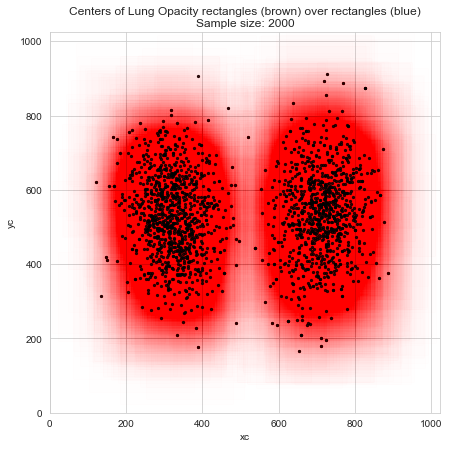

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (blue)\nSample size: 2000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="black")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="red"))
plt.show()

## We next consider 2000 samples of pneumonia data and jot the center of the binding boxes
## The red patches are the entire boxes and black points are the center of those boxes
## With this we get an very important idea that no specific part of the lung may be prone to opacity
## Almost we have every part of lung in 2000 samples has opacity

In [ ]:
image_train_path = os.listdir('stage_2_train_images')
image_test_path = os.listdir('stage_2_test_images')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 3000


## So we check the train and test set, train set excluding repeated images is 26684  and test has 3000 samples
## This much data is good to train a Deep learning model from scratch with decent accuracy and more than enough to feed pre trained model

In [ ]:
print("Unique patientId in  training set: ", train2['patientId'].nunique())

Unique patientId in  training set:  26684


In [ ]:
samplePatientID = list(train2[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join('stage_2_train_images',samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

## Above we check how dicom metadat looks like

In [ ]:
patientId = train2['patientId'][0]
dcm_file = f'stage_2_train_images/{patientId}.dcm'
dcm_data = dcm.read_file(dcm_file)
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


## Also we see that above, our images are numpy arrays with dimension 1024x1024
## These dimensions are perfect for training model as they are AI friendly, not extremely high dimensiona nor extremely pixalated
## This saves us from image transformation or any sort of data compression

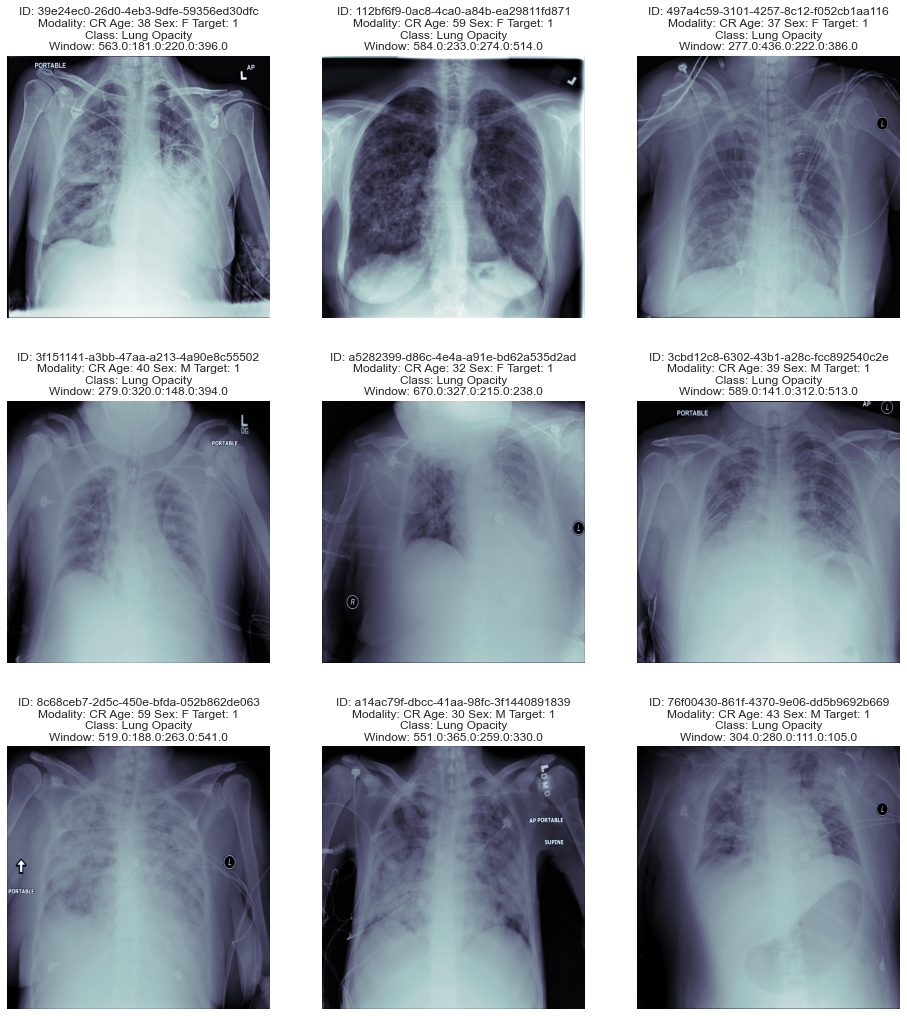

In [ ]:
show_dicom_images(train2[train2['Target']==1].sample(9))

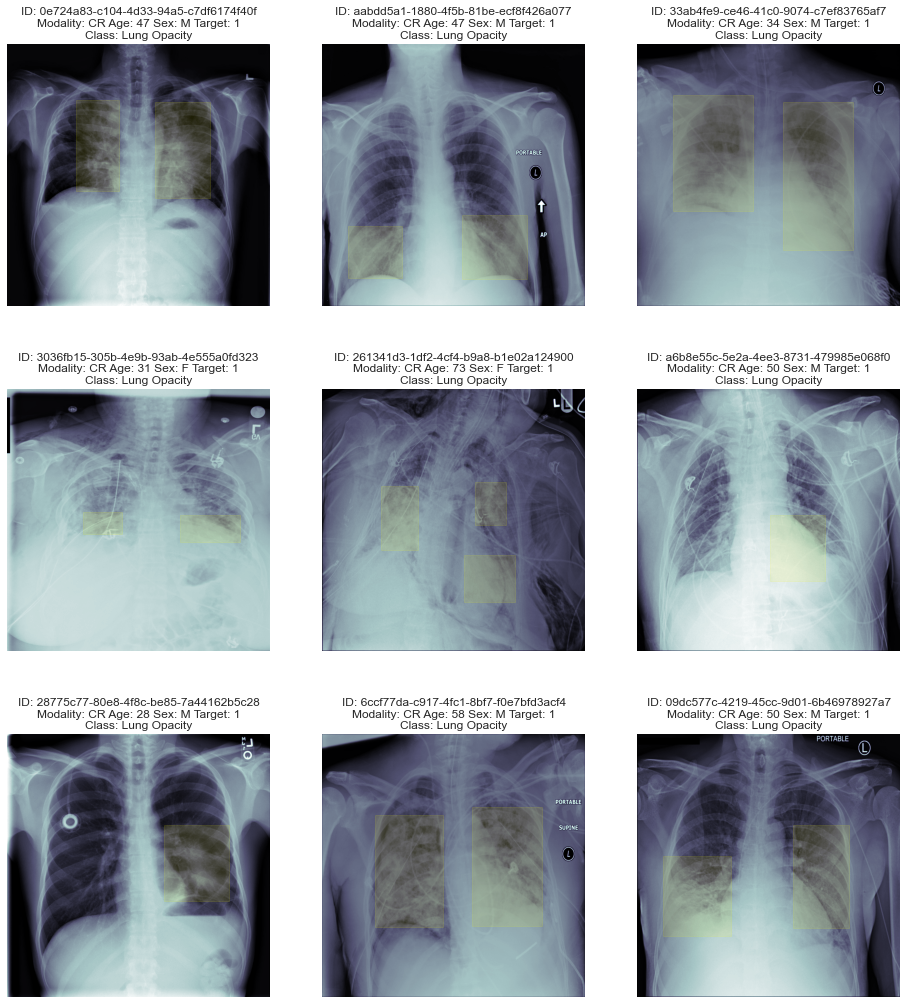

In [ ]:
show_dicom_images_with_boxes(train2[train2['Target']==1].sample(9))

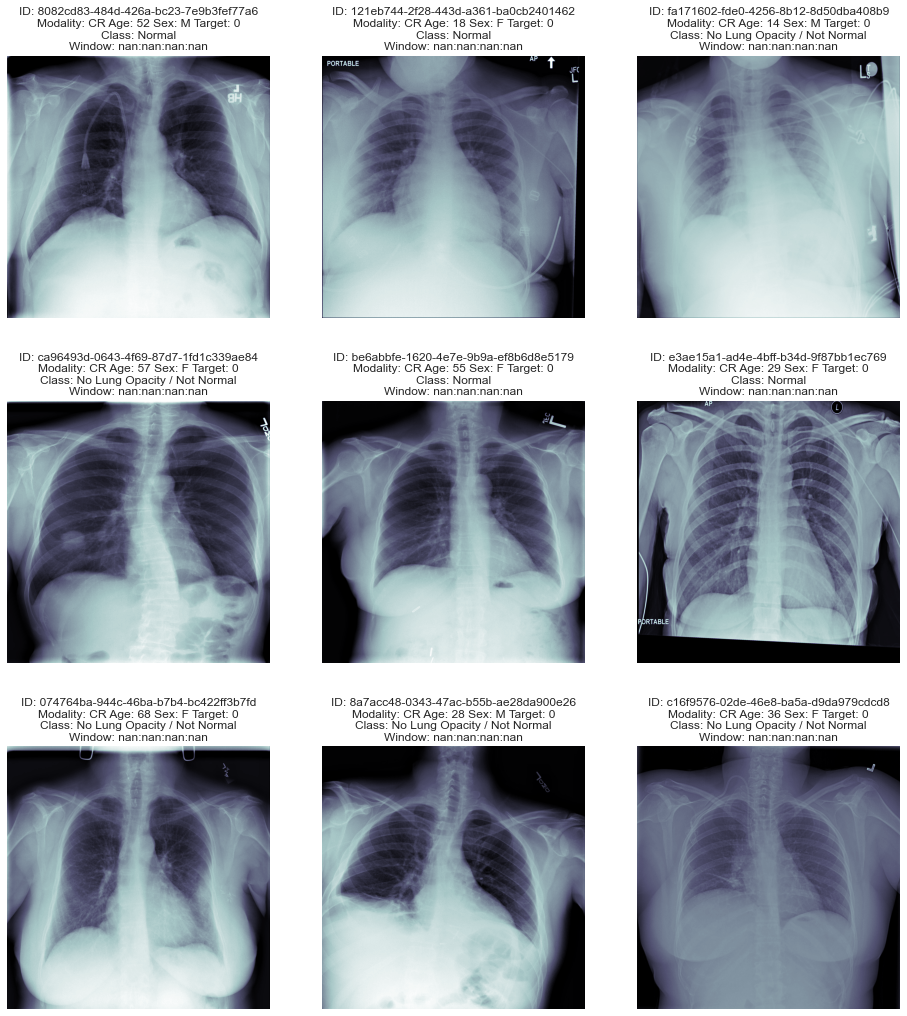

In [ ]:
show_dicom_images(train2[train2['Target']==0].sample(9))

## Above we visualise the images along with basic dicom metadat
## We see positive class as well as negative class and also with binding boxes
## One thing that is evident above is the opacity is not visually identifyable

In [ ]:
train_labels_df = pd.read_csv('/drive/MyDrive/GL_AIML/Capstone/stage_2_train_labels.csv')
class_info_df = pd.read_csv('/drive/MyDrive/GL_AIML/Capstone/stage_2_detailed_class_info.csv')

In [ ]:
TRAIN_PATH = "/drive/MyDrive/GL_AIML/Capstone/stage_2_train_images"
TEST_PATH = "/drive/MyDrive/GL_AIML/Capstone/stage_2_test_images"
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')
image_sample_path = os.listdir(PATH+'/stage_2_train_images')[:5]
image_train_path = os.listdir(PATH+'/stage_2_train_images')
image_test_path = os.listdir(PATH+'/stage_2_test_images')

In [ ]:
pneumonia_locations = {}
with open(os.path.join(PATH+'/stage_2_train_labels.csv'), mode='r') as infile:
    reader = csv.reader(infile)
    next(reader, None)
    for rows in reader:
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        if pneumonia == '1':
            location = [int(float(i)) for i in location]
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

## Next we make a block of code to get all the positive samples into a dictionary.

In [ ]:
folder = PATH+'/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

n train samples 24154
n valid samples 2560
Total train images: 26714
Images with pneumonia: 6012


## Next we split into train and validation

In [ ]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        msk = np.zeros(img.shape)
        if filename in pneumonia_locations:
            for location in pneumonia_locations[filename]:
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        msk = resize(msk, (self.image_size, self.image_size), mode='symmetric') > 0.5
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.predict:
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            imgs = np.array(imgs)
            return imgs, filenames
        else:
            items = [self.__load__(filename) for filename in filenames]
            imgs, msks = zip(*items)
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            return int(len(self.filenames) / self.batch_size)

## Next we make a generator class whihc has load data, get data and predict data functions

In [ ]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x


def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    addInput = x;
    print("Add input shape:", addInput.shape)
    print("Resnet block input shape:", inputs.shape)
    resBlockOut = keras.layers.add([addInput, inputs])
    print("Resnet block out shape:", resBlockOut.shape)
    out = keras.layers.concatenate([resBlockOut, addInput], axis=3)
    print("concat block out shape:", out.shape)
    out = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(out)
    print("mixed block out shape:", out.shape)
    return out

def create_network(input_size, channels, n_blocks=2, depth=4):
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Next we write functions to downsample the data(Since positive class is very less than negative class), create resnet layers and complete the network.

In [ ]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

## Next we write functions to get jaccord loss metric

In [ ]:
model = create_network(input_size=128, channels=16, n_blocks=2, depth=3)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])
print("model summary:", model.summary())
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Add input shape: (?, 64, 64, 32)
Resnet block input shape: (?, 64, 64, 32)
Resnet block out shape: (?, 64, 64, 32)
concat block out shape: (?, 64, 64, 64)
mixed block out shape: (?, 64, 64, 32)
Add input shape: (?, 64, 64, 32)
Resnet block input shape: (?, 64, 64, 32)
Resnet block out shape: (?, 64, 64, 32)
concat block out shape: (?, 64, 64, 64)
mixed block out shape: (?, 64, 64, 32)
Add input shape: (?, 32, 32, 64)
Resnet block input shape: (?, 32, 32, 64)
Resnet block out shape: (?, 32, 32, 64)
concat block out shape: (?, 32, 32, 128)
mixed block out shape: (?, 32, 32, 64)
Add input shape: (?, 32, 32, 64)
Resnet block input shape: (?, 32, 32, 64)
Resnet block out shape: (?, 32, 32, 64)
concat block out shape: (?, 32, 32, 128)
mixed block out shape: (?, 32, 32, 64)
Add input shape: (?, 16, 16, 128)
Resnet block input shape: (?, 16, 16, 128)
Resnet block out shape: (?, 16, 16, 128)
concat block out shape:

## We make a model with 28 Convolution layers with clubbed with leaky relu and batch normalisation layers

In [ ]:
folder = PATH+'/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=False, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=False, predict=False)
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=10, shuffle=True, verbose=2)

Epoch 1/10
(from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
1507/1507 - 2646s - loss: 0.4735 - accuracy: 0.8636 - mean_iou: 0.6307 - val_loss: 0.6701 - val_accuracy: 0.6345 - val_mean_iou: 0.2398 - lr: 0.0010
Epoch 2/10
1507/1507 - 2277s - loss: 0.4450 - accuracy: 0.8668 - mean_iou: 0.6784 - val_loss: 0.4906 - val_accuracy: 0.6479 - val_mean_iou: 0.7674 - lr: 9.9606e-04
Epoch 3/10
1507/1507 - 2515s - loss: 0.4344 - accuracy: 0.9363 - mean_iou: 0.6933 - val_loss: 0.4465 - val_accuracy: 0.7194 - val_mean_iou: 0.7169 - lr: 9.8429e-04
Epoch 4/10
1507/1507 - 2618s - loss: 0.4286 - accuracy: 0.9385 - mean_iou: 0.6959 - val_loss: 0.4256 - val_accuracy: 0.7298 - val_mean_iou: 0.7254 - lr: 9.6489e-04
Epoch 5/10
1507/1507 - 2469s - loss: 0.4217 - accuracy: 0.9497 - mean_iou: 0.7069 - val_loss: 0.4358 - val_accuracy: 0.7421 - val_mean_iou: 0.7355 - lr: 9.3815e-04
Epoch 6/10
1507/1507 - 2573s - loss: 0.4173 - accuracy: 0.9400 

In [ ]:
for i in range(image_test_path):
    test_im_gray.append((np.dot(test_im[i], [0.2989, 0.5870, 0.1140])))
test_im_gray = np.array(test_im_gray)
test_labels = np.array(test_labels)
test_loss, test_acc = model.evaluate(test_im_gray,  test_labels, verbose=2)


Test accuracy: 0.8124


## Next we train and test the model and see we have got Val accuracy of 0.8391 and test accuracy of 0.8124 which is not bad for a model trained from scratch.

Validation Accuracy: 83.91%,  Test Accuracy: 81.24%

## Next we try our hands on transfer learning by using pre-trained models.
## First we try VGG 19

In [ ]:
df=pd.read_csv('/drive/MyDrive/GL_AIML/Capstone/stage_2_train_labels.csv')
df['path']='/drive/MyDrive/GL_AIML/Capstone/stage_2_train_images/'+df['patientId'].astype(str)+'.dcm'

In [ ]:
try:
    os.mkdir('/drive/MyDrive/GL_AIML/Capstone/data')
    os.mkdir('/drive/MyDrive/GL_AIML/Capstone/data/positive')
    os.mkdir('/drive/MyDrive/GL_AIML/Capstone/data/negative')
    os.chdir('/drive/MyDrive/GL_AIML/Capstone')
except:
    pass

In [ ]:
for _,row in tqdm(unique_positive.iterrows()):
    img=pydicom.read_file(row['path']).pixel_array
    img=resize(img,(256,256))
    plt.imsave('data/positive/'+row['patientId']+'.jpg',img,cmap='gray')
for _,row in tqdm(negative.iterrows()):
    img=pydicom.read_file(row['path']).pixel_array
    img=resize(img,(256,256))
    plt.imsave('data/negative/'+row['patientId']+'.jpg',img,cmap='gray')

In [ ]:
datagen=ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True,horizontal_flip=True,
                          width_shift_range=0.05,rescale=1/255,fill_mode='nearest',height_shift_range=0.05,
                           preprocessing_function=preprocess_input,validation_split=0.3,
                          )

In [ ]:
train=datagen.flow_from_directory('data',color_mode='rgb',batch_size=32,
                                  class_mode='binary',subset='training')
test=datagen.flow_from_directory('data',color_mode='rgb',batch_size=32,
                                 class_mode='binary',subset='validation')

In [4]:
pre_trained_model = VGG19(input_shape = (256,256,3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

80142336/80134624 [==============================] - 1s 0us/step
last layer output shape:  (None, 8, 8, 512)


In [5]:
model = Flatten()(last_output)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1, activation='sigmoid')(model)

In [6]:
fmodel = Model( pre_trained_model.input, model) 

fmodel.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
fmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
early=EarlyStopping(monitor='accuracy',patience=3,mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, 
                              patience=2, verbose=1,cooldown=0, mode='auto',min_delta=0.0001, min_lr=1e-5)

In [ ]:
class_weight={0:1,1:3.3}
fmodel.fit(train,epochs=10,callbacks=[reduce_lr],
           steps_per_epoch=100,validation_data=test,class_weight=class_weight)

Epoch 1/10
100/100 [==============================] - 7985s 162s/step - loss: 1.2630 - accuracy: 0.5153 - val_loss: 0.8171 - val_accuracy: 0.2253
Epoch 2/10
100/100 [==============================] - 7930s 160s/step - loss: 1.4530 - accuracy: 0.5392 - val_loss: 0.9142 - val_accuracy: 0.2366
Epoch 3/10
100/100 [==============================] - 7928s 163s/step - loss: 1.3823 - accuracy: 0.5643 - val_loss: 0.6749 - val_accuracy: 0.3747
Epoch 4/10
100/100 [==============================] - 7900s 160s/step - loss: 1.4660 - accuracy: 0.6153 - val_loss: 0.6178 - val_accuracy: 0.4153
Epoch 5/10
100/100 [==============================] - 7840s 159s/step - loss: 1.4550 - accuracy: 0.6891 - val_loss: 0.6744 - val_accuracy: 0.5561
Epoch 6/10
100/100 [==============================] - 7936s 161s/step - loss: 1.4023 - accuracy: 0.6949 - val_loss: 0.6045 - val_accuracy: 0.6087
Epoch 7/10
100/100 [==============================] - 7988s 160s/step - loss: 1.3342 - accuracy: 0.7183 - val_loss: 0.7171 -

In [ ]:
for i in range(image_test_path):
    test_im_gray.append((np.dot(test_im[i], [0.2989, 0.5870, 0.1140])))
test_im_gray = np.array(test_im_gray)
test_labels = np.array(test_labels)
test_loss, test_acc = fmodel.evaluate(test_im_gray,  test_labels, verbose=2)


Test accuracy: 0.7016


## VGG19 gives us a test accuracy of 70%

## Next we try Inception v3

In [7]:
pre_trained_model = InceptionV3(input_shape = (256,256,3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization_2[0][0]      
______________________

In [8]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 2048)


In [9]:
model = Flatten()(last_output)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1, activation='sigmoid')(model)

In [10]:
fmodel = Model( pre_trained_model.input, model) 

fmodel.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
fmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [ ]:
class_weight={0:1,1:3.3}
fmodel.fit(train,epochs=10,callbacks=[reduce_lr],
           steps_per_epoch=100,validation_data=test,class_weight=class_weight)


Epoch 1/10
100/100 [==============================] - 2318s 47s/step - loss: 1.8238 - accuracy: 0.5601 - val_loss: 1.0611 - val_accuracy: 0.3570
Epoch 2/10
100/100 [==============================] - 1632s 33s/step - loss: 1.2832 - accuracy: 0.6293 - val_loss: 0.7278 - val_accuracy: 0.3896
Epoch 3/10
100/100 [==============================] - 1605s 33s/step - loss: 1.9978 - accuracy: 0.6652 - val_loss: 0.6458 - val_accuracy: 0.4274
Epoch 4/10
100/100 [==============================] - 1528s 41s/step - loss: 1.8238 - accuracy: 0.6601 - val_loss: 0.6611 - val_accuracy: 0.4570
Epoch 5/10
100/100 [==============================] - 1231s 28s/step - loss: 1.2832 - accuracy: 0.6823 - val_loss: 0.5878 - val_accuracy: 0.5076
Epoch 6/10
100/100 [==============================] - 1235s 32s/step - loss: 0.9978 - accuracy: 0.7652 - val_loss: 0.5458 - val_accuracy: 0.5364
Epoch 7/10
100/100 [==============================] - 1116s 46s/step - loss: 1.1238 - accuracy: 0.6601 - val_loss: 0.6611 - val_ac

In [ ]:
for i in range(image_test_path):
    test_im_gray.append((np.dot(test_im[i], [0.2989, 0.5870, 0.1140])))
test_im_gray = np.array(test_im_gray)
test_labels = np.array(test_labels)
test_loss, test_acc = fmodel.evaluate(test_im_gray,  test_labels, verbose=2)

Test accuracy: 0.6128


## Inception v3 gives us an accuracy of 61%

## Next we use mobile net

In [11]:
pre_trained_model = MobileNetV2(input_shape = (256,256,3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 32) 0           bn_Conv1[0][0]                   
________________

In [14]:
last_layer = pre_trained_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 8, 8, 1280)


In [15]:
model = Flatten()(last_output)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1, activation='sigmoid')(model)

In [16]:
fmodel = Model( pre_trained_model.input, model) 

fmodel.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
fmodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
class_weight={0:1,1:3.3}
fmodel.fit(train,epochs=10,callbacks=[reduce_lr],
           steps_per_epoch=100,validation_data=test,class_weight=class_weight)

Epoch 1/10
100/100 [==============================] - 870s 18s/step - loss: 1.6388 - accuracy: 0.6194 - val_loss: 1.2676 - val_accuracy: 0.5668
Epoch 2/10
100/100 [==============================] - 860s 17s/step - loss: 1.1488 - accuracy: 0.6637 - val_loss: 0.9398 - val_accuracy: 0.5994
Epoch 3/10
100/100 [==============================] - 806s 16s/step - loss: 0.9868 - accuracy: 0.6997 - val_loss: 0.8377 - val_accuracy: 0.5702
Epoch 4/10
100/100 [==============================] - 841s 17s/step - loss: 0.9124 - accuracy: 0.7014 - val_loss: 0.9145 - val_accuracy: 0.5698
Epoch 5/10
100/100 [==============================] - 890s 16s/step - loss: 0.8846 - accuracy: 0.7388 - val_loss: 0.9688 - val_accuracy: 0.6059
Epoch 6/10
100/100 [==============================] - 804s 14s/step - loss: 0.8510 - accuracy: 0.8016 - val_loss: 0.7315 - val_accuracy: 0.6321
Epoch 7/10
100/100 [==============================] - 789s 13s/step - loss: 0.8377 - accuracy: 0.8487 - val_loss: 0.7624 - val_accuracy:

In [ ]:
for i in range(image_test_path):
    test_im_gray.append((np.dot(test_im[i], [0.2989, 0.5870, 0.1140])))
test_im_gray = np.array(test_im_gray)
test_labels = np.array(test_labels)
test_loss, test_acc = fmodel.evaluate(test_im_gray,  test_labels, verbose=2)

Test accuracy: 0.7311


## We get 73% accuracy for mobilent

# Comparision

In [12]:
met_df=pd.DataFrame(acc, columns=cols)
met_df

Model  Ep_1_TrainLoss  Ep_1_TrainAcc  Ep_1_ValLoss  \
0     CNN_Resnet_Scratch_Trained          0.4735         0.8636        0.6701   
1        VGG19_Transfer_Learning          1.2630         0.5153        0.8171   
2  InceptionV3_Transfer_Learning          1.8238         0.5601        1.0611   
3   MobileNet_Transfer_ Learning          1.6388         0.6194        1.2676   

   Ep_1_ValAcc  Ep_2_TrainLoss  Ep_2_TrainAcc  Ep_2_ValLoss  Ep_2_ValAcc  \
0       0.6345          0.4450         0.8668        0.4906       0.6479   
1       0.2253          1.4530         0.5392        0.9142       0.2366   
2       0.3570          1.2832         0.6293        0.7278       0.3896   
3       0.5668          1.1488         0.6637        0.9398       0.5994   

   Ep_3_TrainLoss  ...  Ep_8_ValAcc  Ep_9_TrainLoss  Ep1_9_TrainAcc  \
0          0.4344  ...       0.7821          0.4067          0.9716   
1          1.3823  ...       0.6643          1.2823          0.9043   
2          1.9978  ...       0.6086          0.9978          0.6652   
3          0.9868  ...       0.7041          0.6542          0.8903   

   Ep_9_ValLoss  Ep_9_ValAcc  Ep_10_TrainLoss  Ep1_10_TrainAcc  Ep_10_ValLoss  \
0        0.4147       0.8019           0.4044           0.9716         0.4095   
1        0.6849       0.7047           1.2243           0.9125         0.6089   
2        0.5458       0.6463           0.9176           0.7052         0.5216   
3        0.6834       0.7245           0.6680           0.8826         0.6767   

   Ep_10_ValAcc  Test_Accuracy  
0        0.8391            83%  
1        0.7447            70%  
2        0.6874            61%  
3        0.7638            73%  

[4 rows x 42 columns]

In [13]:
met_df.to_csv('met_df.csv',index=False)

## Thus we have trained a model from scratch and tested the same, Also we have tested three popular models as well with the test data and these are the Accuracy results.
### Resnet Trained from scratch: 81%
### VGG19, pretrained: 70%
### Inception V3, pretrained: 61%
### Mobilenet, pretrained: 73%

# -  Final Verdict and discussion:
### We decide to go with our cnn resnet model trained from scratch for the following reason:
#### - Models trained from scracth can be changed as per requirements
#### - A lot of hyperparameter tuning can be made if necessary
#### - Gives us good accuracy since our train data set is properly fit on it
#### - Pre trained models can be used if computation is a barrier
#### - In case of faster training or need to use rEnforcement learning, we can go for pre trained models
#### - Mobilenet has promising results if faster running is desired(Since a light model)
#### - But for this project we shall zero down on our CNN, Resnet model which is trained from scracth giving us a good accuracy of 81%

## Finally we see a few of our test images by our prediction chosen algorithm in action
## Red box is ground truth, blue box is prediction

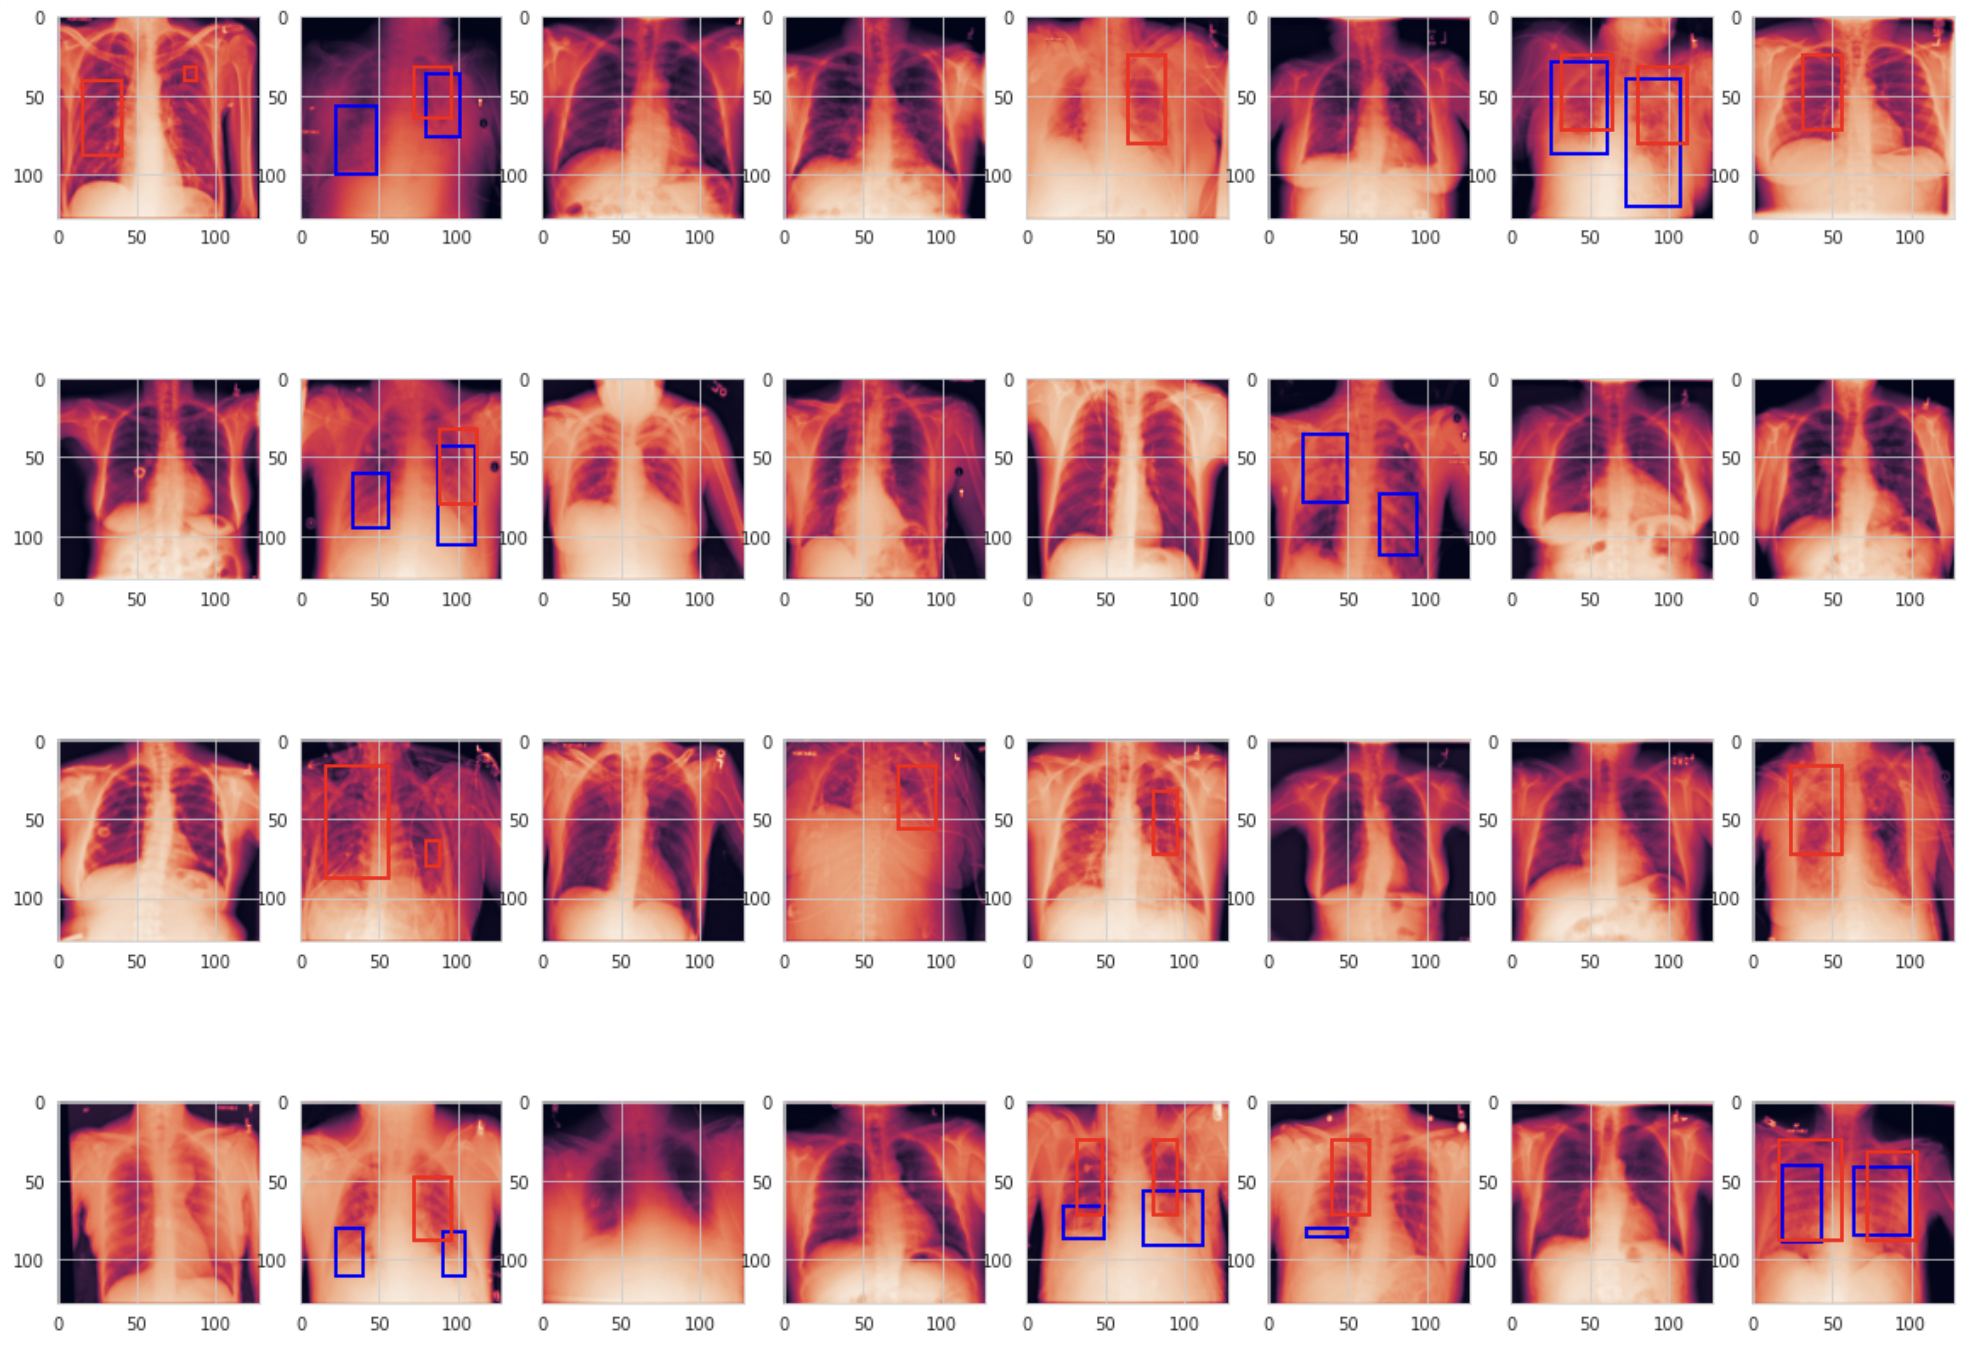

In [ ]:
for imgs, msks in valid_gen:
    preds = model.predict(imgs)
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    for img, msk, pred in zip(imgs, msks, preds):
        axarr[axidx].imshow(img[:, :, 0])
        comp = msk[:, :, 0] > 0.5
        comp = measure.label(comp)
        predictionString = ''
        for region in measure.regionprops(comp):
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        comp = pred[:, :, 0] > 0.5
        comp = measure.label(comp)
        predictionString = ''
        for region in measure.regionprops(comp):
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    break